In [1]:
import sys
import glob
import re
import fnmatch
import math
import re
import os
from os import listdir
from os.path import join, isfile, basename

import itertools

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

from scipy.stats import ttest_ind

import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, FormatStrFormatter

import seaborn as sns

import colorsys

from template_common import *

In [3]:
# Generate the time table from raw data
## See Vis_Pairwise_alg-temp 

In [4]:
# table_f='/groups/saalfeld/home/bogovicj/pubDrafts/grpDrosTemplate/grpDrosTemplate/table.dat'
table_f='/groups/saalfeld/home/bogovicj/pubDrafts/grpDrosTemplate/grpDrosTemplate/table_20180502.csv'

table_raw = pd.read_csv( table_f,
                         names=['ALG','TEMPLATE','MEAN_D','MEDIAN_D','GMODE_D','CPUTIME'])


In [5]:
# Filter the table

regexp=re.compile('\s+ANTs Wolf')
table = table_raw[ table_raw.apply( lambda x: ( regexp.search( x['ALG'] ) is None ), axis=1)]


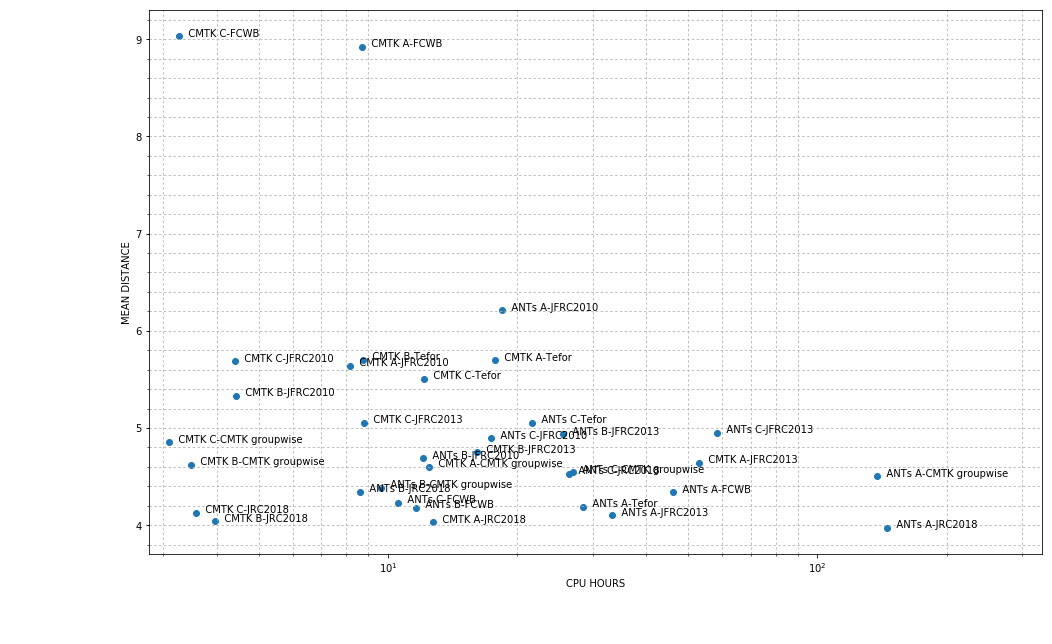

In [8]:
plt.scatter( table.CPUTIME/3600., table.MEAN_D )
plt.xlabel('CPU HOURS')
plt.ylabel('MEAN DISTANCE')

ax = plt.gca()
for i,row in table.iterrows():

    dist = '%0.2f' % (row['MEAN_D'])
    time = '%0.1fh' % (row['CPUTIME'])
#     s = "   " + alg_name_map[row['ALG'].lstrip(' ')] + "-" + template_name_map[(row['TEMPLATE']).lstrip(' ')]
    s = "   " + alg_name(row['ALG'].lstrip(' ').rstrip(' ')) + "-" + template_name((row['TEMPLATE']).lstrip(' '))
#     s = "   " + row['ALG'].lstrip(' ') + "-" + (row['TEMPLATE']).lstrip(' ')
    ax.annotate( s, (row['CPUTIME']/3600., row['MEAN_D'] ) )
    
ax.set_xscale('log')

ax.yaxis.set_minor_locator( MultipleLocator(0.2) )
plt.grid( which='minor', linestyle=':', dashes=(3,3))

plt.xlim(10000./3600,1200000./3600)

fig = plt.gcf()
a = fig.set_size_inches( 16, 10 )
fout_prefix="/groups/saalfeld/home/bogovicj/pubDrafts/grpDrosTemplate/grpDrosTemplate/figs/speed_quality_20180503"
plt.savefig(fout_prefix+".svg")
plt.savefig(fout_prefix+".pdf")
plt.savefig(fout_prefix+".png")

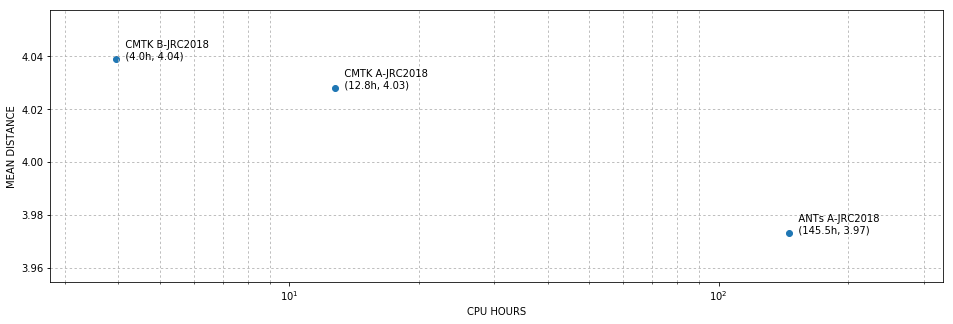

In [9]:
# A table that only shows the 'best' few results
# Where best means having mean distance less than 4.1

goodtable = table[ table.MEAN_D < 4.1 ]

plt.scatter( goodtable.CPUTIME/3600., goodtable.MEAN_D )
plt.xlabel('CPU HOURS')
plt.ylabel('MEAN DISTANCE')

ax = plt.gca()
for i,row in goodtable.iterrows():
    dist = '%0.2f' % (row['MEAN_D'])
    time = '%0.1fh' % (row['CPUTIME']/(3600))
    s = "   " +  alg_name(row['ALG'].lstrip(' ')) + "-" + template_name((row['TEMPLATE']).lstrip(' ')) + "\n   (" + time + ", " + dist + ")"
    ax.annotate( s, (row['CPUTIME']/3600., row['MEAN_D'] ) )

ax.set_xscale('log')
# ax.xaxis.set_ticks(np.arange( 0, 550000, 10000 ))
ax.yaxis.set_minor_locator( MultipleLocator(0.02) )

plt.xlim(10000/3600.,1200000/3600.)

# plt.grid()
plt.grid( which='minor', linestyle=':', dashes=(3,3))


fig = plt.gcf()
a = fig.set_size_inches( 16, 5 )
fout_prefix="/groups/saalfeld/home/bogovicj/pubDrafts/grpDrosTemplate/grpDrosTemplate/figs/speed_quality_best_20180503"
# plt.savefig(fout_prefix+".svg")
# plt.savefig(fout_prefix+".pdf")
# plt.savefig(fout_prefix+".png")